This "search engine" is designed to search for the segment with the most similar rhythmic pattern to phrase endings in Mozart's K448 in MAESTRO Dataset.

**1. Tempo Estimation**
     
* Searching for songs that contains at least one segment of 30-s with tempo between 120 to 144 BPM.
* Run `python3 filter_by_tempo.py` to get `maestro_selected.csv` a list of file names to the selected music in MAESTRO dataset. (Takes 73 min to run through the dataset.)
   
**2. Feature Extraction**

* Calculate periodicity/beat spectra within 10-s segments with 5-s hop size for each selected song from the dataset and around phrase boundaries in Mozart's K448.  

**3. Music Retrieval**

* Calculate the similarity between the periodicity/beat spectra each segment and the phrase boundaries in Mozart's K448. 
* Rank the segments by their similarities.
* Rank the songs by their similarities.

## Feature Extraction

Run `python3 ./src/periodicity.py` to calculate periodicity spectrogram of the songs with appropriate tempo range. The result is saved as a `maestro_selected.npz` file. An example of calling functions from `./src/periodicity.py` to calculate periodicty spectra is shown below.

### Periodicity Spectra of K448 and K545

In [1]:
import librosa
import numpy as np

In [2]:
# Calculating the spectra of segments around phrase boundaries in Mozart's K448
from src.periodicity import periodicity_spectrum

fname_k448 = "../ss2/Stimulus/K448orig_120.wav"
t_duration = 100
t_frame = 10
y_k448, sr = librosa.load(fname_k448, offset=0, duration=t_duration)

# Phrase boundaries in the first 90-s of Mozart's K448 (which proved to have the Mozart's effect), 
# Among these boundaries, only 0,4,5,6,7 showing changes in note density.
t_pharse_boundary = [8.267483,
                     15.314673,
                     29.164994,
                     39.476467,
                     42.954301,
                     59.184194,
                     74.620896,
                     88.074622]

t_st = np.array(t_pharse_boundary) - t_frame/2

## Alternatively, picking segments around decreases in note density

# note_drop = dict(np.load("../Rhythmic/data/note_density/drop.npz"))['K448orig_120']
# drop_time = np.arange(0.5, 90, 0.5)[note_drop > 1]
# t_st = drop_time[(drop_time > t_win/2) & (drop_time <= t_duration-t_win/2)]-5

D = np.abs(librosa.feature.melspectrogram(y=y_k448, sr=sr))
onset_env = librosa.onset.onset_strength(S=librosa.core.power_to_db(D), sr=sr)

times = librosa.times_like(D, sr=sr)
onset_env_sr = np.mean(1 / np.diff(times))

frame_len = int(t_frame * onset_env_sr)

spectra = []

for t in t_st:
    idx_st = int(t * onset_env_sr)
    spectrum = periodicity_spectrum(onset_env=onset_env[idx_st:idx_st + frame_len])
    spectra.append(spectrum)
    
# np.save("./data/periodicity_spectra/K448orig_120_phrase_boundary.npy")

In [3]:
# Calculating the spectrogram of the entire Mozart's K545
from src.periodicity import periodicity_spectrogram

fname_k545 = "./data/audio/Sonata in C Major K545： I. Allegro.mp3"
y_k545, sr = librosa.load(fname_k545)
spectrogram = periodicity_spectrogram(y_k545)

# np.save("./data/periodicity_spectra/K545.npy")

/usr/local/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## Ranking by Similarity

### Calculating Similarity

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm

ref_ps = dict(np.load("./data/periodicity_spectra/K448orig_120_phrase_boundary.npz"))['spectra']
ref_ps = (ref_ps.T/norm(ref_ps, axis=1)).T # normalization

ps = dict(np.load("./data/periodicity_spectra/maestro_selected.npz", allow_pickle=True))['p_f'] # or 'spectra'

**1. Cosine Similarity**

$\text{similarity} = \frac{\text{S}_1 \cdot \text{S}_2}{\left\| \text{S}_1 \right\| \left\| \text{S}_2 \right\|}$

In [2]:
scores = []

for ps_i in ps:
    
    # normalize
    ps_i = np.array(ps_i.T)
    ps_i = ps_i/norm(ps_i, axis=0)
    
    scores.append(np.dot(np.array(ps_i).T, ref_ps.T))
    
scores = np.array(scores, dtype=object)
# np.savez_compressed("./data/similarity/cos_sim.npz", **{'score': scores}, allow_pickle=True)

**2. Dynamic Periodicity Warping Distance**

DPW score should be invariant to small tempo changes. 

It takes 20 hrs to run through the entire dataset. So, here we just show an example of calculating dpw distance between 1 query, i.e. 1 spectrum from K448 and 1 segment from the database. 

See `DPW.ipynb` for more details. 

In [3]:
from src.dpw import DPW_distance

ps_0 = (ps[0]/norm(ps[0], axis=0))[0]

dist = DPW_distance(ps_0, ref_ps[0])
self_dist = DPW_distance(ps_0, ps_0)

print(f"sample distance: {dist:.4f}")
print(f"self distance: {self_dist:4f}")

sample distance: 10.3324
self distance: 0.000000


## Retrieval

In [1]:
import numpy as np
import pandas as pd

# Load metadata of selected songs from MAESTRO
df = pd.read_csv("./metadata/maestro_selected.csv")

# We only care about phrase boundaries at which note density drops
# the indices of these phrase boundaries:
pb_idx = [0,4,5,6,7]


# Load cosine similarity
cos_scores = dict(np.load("./data/similarity/cos_sim.npz", allow_pickle=True))['score']
cos_scores = [score[:,pb_idx] for score in cos_scores]

# Load dpw distance
dpw_dist = dict(np.load("./data/similarity/dpw_dist.npz", allow_pickle=True))['dist']
dpw_dist = [np.array(dist) for dist in dpw_dist]

# Convert distance to similarity
dpw_scores = [1/dist[:,pb_idx] for dist in dpw_dist]

### Retrieve the Segments

Searching for most similar segments using different similarity metrics. Use `trim_audio.sh` in `./src` to retrieve Top k similar segments given a csv file of these segments. 

#### Sort by Max Score

In [2]:
# Sort by the max similarity between each segment from the dataset and 5 phrase boundaries in Mozart's K448
from src.ranking import sort_max

max_cos_scores = [np.max(score, axis=1) for score in cos_scores]
sorted_max_cos_scores = sort_max(max_cos_scores)

max_dpw_scores = [np.max(score, axis=1) for score in dpw_scores]
sorted_max_dpw_scores = sort_max(max_dpw_scores)

In [17]:
# Showing Top 10 most similar segments for different similarity metrics
from src.ranking import print_top_k_seg

max_cos_top_k = print_top_k_seg(sorted_max_cos_scores, df)
print("Top 10 by Cosine Similarity")

max_cos_top_k[['composer', 'title', 'start']]

Top 10 by Cosine Similarity


,composer,title,start
0,Wolfgang Amadeus Mozart,"Rondo in A Minor, K. 511",00:00:15
1,Franz Schubert,"Fantasia in C Major, ""Wanderer"", D. 760",00:04:10
2,Johann Sebastian Bach,"Prelude and Fugue in B-flat Minor, WTC I, BWV 867",00:03:00
3,Joseph Haydn,"Sonata in C major, Hob. XVI: 50",00:11:00
4,Nikolai Medtner,Two Fairy Tales,00:05:50
5,Wolfgang Amadeus Mozart,"Nine Variations, K. 264",00:03:20
6,Robert Schumann,"Carnaval, Op. 9",00:22:00
7,Johann Sebastian Bach,"Prelude and Fugue in B Major, WTC I, BWV 868",00:01:55
8,Franz Schubert,Sonata in B-flat Major D. 962,00:02:45
9,Robert Schumann,"Sonata No. 1 in F-sharp Minor, Op. 11",00:06:20


In [18]:
max_dpw_top_k = print_top_k_seg(sorted_max_dpw_scores, df)
print("Top 10 by DPW Similarity")

max_dpw_top_k[['composer', 'title', 'start']]

Top 10 by DPW Similarity


,composer,title,start
0,Robert Schumann,"Sonata No. 2 in G Minor, Op. 22 (Complete)",00:09:15
1,Franz Schubert,"Sonata in D Major, D850",00:33:45
2,Franz Liszt,"Sonata in B Minor, S. 178",00:10:50
3,Franz Schubert,"Sonata in G Major, D. 896",00:02:45
4,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",00:00:45
5,Frédéric Chopin,Polonaise-Fantasie Op. 61,00:00:10
6,Ludwig van Beethoven,"Sonata No. 28 in A Major, Op. 101 (Complete)",00:03:55
7,Franz Liszt,"Rhapsodie Espagnole, S. 254",00:06:10
8,Isaac Albéniz,"Iberia, Evocation, Triana",00:04:45
9,Wolfgang Amadeus Mozart,"Sonata in D Major, K.311",00:00:00


#### Sort All Score

In [19]:
from src.ranking import sort_all

sorted_cos_scores = sort_all(cos_scores)
sorted_dpw_scores = sort_all(dpw_scores)

In [20]:
cos_top_k = print_top_k_seg(sorted_cos_scores, df)
print("Top 10 by Cosine Similarity")

cos_top_k[['composer', 'title', 'start']]

Top 10 by Cosine Similarity


,composer,title,start
0,Wolfgang Amadeus Mozart,"Rondo in A Minor, K. 511",00:00:15
1,Franz Schubert,"Fantasia in C Major, ""Wanderer"", D. 760",00:04:10
2,Johann Sebastian Bach,"Prelude and Fugue in B-flat Minor, WTC I, BWV 867",00:03:00
3,Joseph Haydn,"Sonata in C major, Hob. XVI: 50",00:11:00
4,Nikolai Medtner,Two Fairy Tales,00:05:50
5,Wolfgang Amadeus Mozart,"Nine Variations, K. 264",00:03:20
6,Robert Schumann,"Carnaval, Op. 9",00:22:00
7,Johann Sebastian Bach,"Prelude and Fugue in B Major, WTC I, BWV 868",00:01:55
8,Franz Schubert,Sonata in B-flat Major D. 962,00:02:45
9,Robert Schumann,"Sonata No. 1 in F-sharp Minor, Op. 11",00:06:20


In [21]:
dpw_top_k = print_top_k_seg(sorted_dpw_scores, df)
print("Top 10 by DPW Similarity")

dpw_top_k[['composer', 'title', 'start']]

Top 10 by DPW Similarity


,composer,title,start
0,Robert Schumann,"Sonata No. 2 in G Minor, Op. 22 (Complete)",00:09:15
1,Franz Schubert,"Sonata in D Major, D850",00:33:45
2,Franz Liszt,"Sonata in B Minor, S. 178",00:10:50
3,Franz Schubert,"Sonata in G Major, D. 896",00:02:45
4,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",00:00:45
5,Frédéric Chopin,Polonaise-Fantasie Op. 61,00:00:10
6,Franz Schubert,"Sonata in G Major, D. 896",00:02:45
7,Ludwig van Beethoven,"Sonata No. 28 in A Major, Op. 101 (Complete)",00:03:55
8,Franz Schubert,"Sonata in G Major, D. 896",00:02:45
9,Franz Liszt,"Rhapsodie Espagnole, S. 254",00:06:10


### Retrieve the most similar pieces

Ranking the pieces by the number of similar segments. 

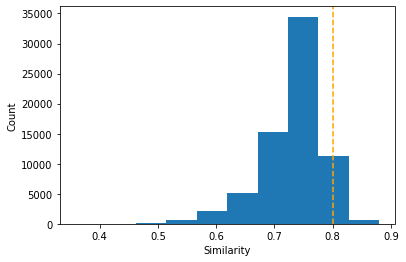

In [32]:
import matplotlib.pyplot as plt

# Define "similar" by setting a threshold of reaching top 5% similarity
thresh_ratio = 0.05
flatten_cos_scores = np.sort(flatten_cos_scores)
thresh = flatten_cos_scores[-int(len(flatten_cos_scores) * thresh_ratio)]

# visualize the similarity score distribution
flatten_cos_scores = np.concatenate([score.flatten() for score in max_cos_scores])

plt.hist(flatten_cos_scores)

plt.axvline(x=thresh, linestyle="--", color='orange')

plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()

In [46]:
# Simply sort by number of similar segments
similar_segment_idx = [(i, np.where(score >= thresh)[0]) for i, score in enumerate(cos_scores)]
sorted_piece = sorted(similar_segment_idx, key=lambda x:len(x[-1]), reverse=True)

In [76]:
top_k_piece = print_top_k_piece(sorted_piece, df, top_k=20)
top_k_piece[['composer', 'title', 'interval']][:10]

,composer,title,interval
0,Franz Schubert,"Sonata in A Major, D. 959 (Complete)","{00:37:20~00:37:35, 00:01:45~00:02:00, 00:04:2..."
1,Ludwig van Beethoven,"Eroica Variations, Op. 35","{00:09:00~00:09:25, 00:05:25~00:06:00, 00:17:5..."
2,Franz Schubert,"Sonata in B-flat Major, D. 963","{00:01:45~00:02:00, 00:02:00~00:02:15, 00:04:5..."
3,Franz Schubert,Sonata in A D959,"{00:03:20~00:03:40, 00:05:40~00:05:55, 00:07:5..."
4,Wolfgang Amadeus Mozart,"Sonata in B-flat Major, K 333, First Movement","{00:00:25~00:00:50, 00:03:40~00:03:55, 00:01:4..."
5,Frédéric Chopin,Sonata 3 Op. 58,"{00:03:50~00:04:05, 00:04:10~00:04:35, 00:07:5..."
6,Franz Schubert,Son. in Bb D.962,"{00:12:05~00:12:35, 00:00:00~00:00:15, 00:11:0..."
7,Ludwig van Beethoven,"Sonata in A-flat, Op. 110","{00:06:55~00:07:10, 00:08:20~00:08:35, 00:13:4..."
8,Franz Schubert,"Sonata in B-flat Major, D960","{00:31:20~00:31:45, 00:32:55~00:33:10, 00:33:5..."
9,Franz Schubert,"Fantasia in C Major, ""Wanderer"", D. 760","{00:12:20~00:12:35, 00:09:05~00:09:25, 00:16:0..."


In [77]:
top_k_piece.to_csv("Top_20_piece.csv", index=False)